In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl 

#__STEP ONE:  Drawing design (Data Input & Check)__

In [71]:
#input data and check
data_input = pd.read_csv('input/nyc-rolling-sales.csv')m
data_input.head(5)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


#__STEP TWO:  Digging Foundation  (Data Cleaning & Data Transformation)__

* We need to delete some columns which is obvious rundunt
>
>1.We found that [__'EAST-MENT', 'APARTMENT NUMBER'__] these two columns are empty and we can drop them;
>
>2.We found that __'BUILDING CLASS CATEGORY '__ is same as the _'BUILDING CLASS OF TIME SALE'_;
>
>3.We know that sum of __'RESIDENTIAL UNITS'__ and __'COMMERCIAL UNIT'__ is __'TOTAL UNIT'__ so we can drop the former two;
>
>4.We now need to predict the sale price so we only need to delete the [__'BUILDING CLASS AT PRESENT'__, __'TAX CLASS AT PRESENT'__]

* We also need to combine some real estate market knowledge
>
>1.When we buy the apartment/house the final sale price relies on the __'GROSS SQUARE FEET'__  but not the __'LAND SQUARE FEET'__;
>
>2.When we wanna predict one real estate price we only need to focus on which the area(__'BOROUGH'__) and zip ocde(__'ZIP CODE'__) it belongs to, but not the specific ___'ADDRESS'___


In [72]:
# Data Cleaning
data_input.drop(data_input[['Unnamed: 0','EASE-MENT','NEIGHBORHOOD','ADDRESS','BUILDING CLASS CATEGORY','BUILDING CLASS AT PRESENT','RESIDENTIAL UNITS','LAND SQUARE FEET','COMMERCIAL UNITS','TAX CLASS AT PRESENT','APARTMENT NUMBER']], axis=1, inplace=True)
data_input['SALE DATE'] = data_input['SALE DATE'].apply(lambda x : x[0:4])
data_input = data_input.iloc[:,:].replace(' -  ',np.nan)

* We need to do __data type tranformation__ on some columns:
>
>1.We know that __'GROSS SQUARE FEET'__ & __'SALE PRICE'__ must be numerical;
>
>2.[__'ZIP CODE','YEAR BUILT','TAX CLASS AT TIME OF SALE'__] should be categories, so we need to transform them to be string which will cause effect from the size of value

In [73]:
# Data type transformation
data_input[['GROSS SQUARE FEET','SALE PRICE']] = data_input[['GROSS SQUARE FEET','SALE PRICE']].astype(float)
data_input[['ZIP CODE','YEAR BUILT','TAX CLASS AT TIME OF SALE']] = data_input[['ZIP CODE','YEAR BUILT','TAX CLASS AT TIME OF SALE']].astype(str)

In [6]:
#check data type
data_input.dtypes

BOROUGH                             int64
BLOCK                               int64
LOT                                 int64
ZIP CODE                           object
TOTAL UNITS                         int64
GROSS SQUARE FEET                 float64
YEAR BUILT                         object
TAX CLASS AT TIME OF SALE          object
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                        float64
SALE DATE                          object
dtype: object

In [43]:
#Seperating Input data into data_train & data_test
data_train = data_input[~pd.isna(data_input['SALE PRICE'])]
data_test = data_input[pd.isna(data_input['SALE PRICE'])]

In [44]:
#Let's show some inforamtion about or training data
data_train.describe()

,BOROUGH,BLOCK,LOT,TOTAL UNITS,GROSS SQUARE FEET,SALE PRICE
count,69987.000000,69987.000000,69987.000000,69987.000000,4.824800e+04,6.998700e+04
mean,2.921928,4196.072528,373.828397,2.092203,3.672552e+03,1.276456e+06
std,1.235688,3429.196524,656.096528,17.276100,2.947540e+04,1.140526e+07
min,1.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00
25%,2.000000,1348.000000,22.000000,0.000000,8.280000e+02,2.250000e+05
50%,3.000000,3378.000000,50.000000,1.000000,1.620000e+03,5.300000e+05
75%,4.000000,6186.000000,709.000000,2.000000,2.520000e+03,9.500000e+05
max,5.000000,16319.000000,9106.000000,2261.000000,3.750565e+06,2.210000e+09


* From the data description we found that our target data(__'SALE PRICE'__) is unstable and we need to do something on it to make it look more smoothy !!!!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D4F4CF8>]],
      dtype=object)

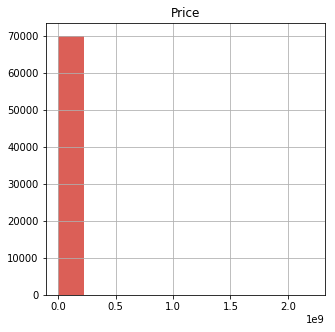

In [46]:
#Show plot about our target data
%matplotlib inline
prices = pd.DataFrame({"Price" :data_train['SALE PRICE']})
prices.hist(figsize = (5,5))

> The __'SALE PRICE'__ data looks so ugly, we need to make up it to make it smoothy
>

In [48]:
#We can get rid of the strange sale price rows
#If difference between sale_price data and sale_price mean value over 2 times of sale_price std, we will think it to be abnomal data
abnomal_data = data_train.loc[data_train["SALE PRICE"] < 10000.0]
data_train = data_train[data_train['SALE PRICE'] > 1000.0]
train_sale_mean = data_train['SALE PRICE'].mean()
train_sale_std = data_train['SALE PRICE'].std()
index_list = []
for i in data_train['SALE PRICE']:
    if i - train_sale_mean > 2 * train_sale_std:
        index_list.append(i)
#print min(index_list)
data_train = data_train[data_train['SALE PRICE'] < 26500000.0]

C:\Users\chenb\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


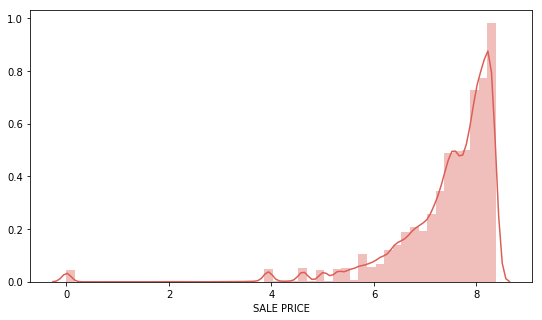

In [49]:
# We need to find out the relatively best std and show the relatively smooth data to you
std_list = []
for i in range(1000, 5000, 50):
    data = data_train['SALE PRICE']
    value = data.apply(lambda x: np.log(x % i + 1))
    std_list.append(value.std())
#print std_list.index(min(std_list))

sns.set_palette("hls")  
mpl.rc("figure", figsize=(9, 5))    
sns.distplot(data_train['SALE PRICE'].apply(lambda x : np.log(x % 4350 + 1)))

>__Wow !!!__ It is beautiful, isn't it ? It looks better than it before.
>
>__Keep Calm !!!!!__
>
>We still need to see is there something strange will threat our target data and we need to fall away them
>

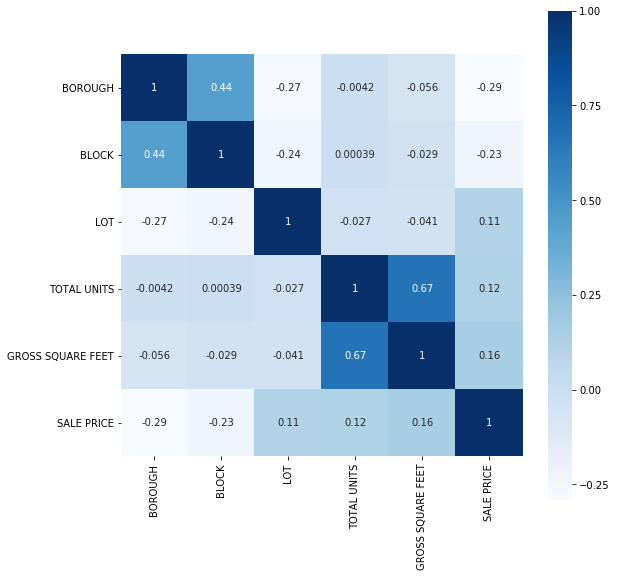

In [51]:
# Show the heatmap about the co-realtionship between var and target data
# And we can find there is no more things that we need to get rid of, they are important to us
def fall_away(df):
    dfData = df.corr()
    plt.subplots(figsize=(9, 9)) 
    sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
    plt.show()
fall_away(data_train)

#__STEP THREE: Construction (Data Feature Engineering)__

In [52]:
# We need to get the target data we need to do training and tests
y_train = data_train.pop('SALE PRICE').apply(lambda x : np.log(x % 4350 + 1))
y_test = data_test.pop('SALE PRICE')

In [53]:
# Combining the remaining data whihc we need to use in the future
all_df = pd.concat((data_train, data_test), axis = 0)
all_df.head()

,BOROUGH,BLOCK,LOT,ZIP CODE,TOTAL UNITS,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE
0,1,392,6,10009,5,6440.0,1900,2,C2,2017
3,1,402,21,10009,10,6794.0,1913,2,C4,2016
4,1,404,55,10009,6,4615.0,1900,2,C2,2016
6,1,406,32,10009,8,4226.0,1920,2,C4,2016
9,1,387,153,10009,24,18523.0,1920,2,D9,2016


In [54]:
# Double check the data type
all_df.dtypes

BOROUGH                             int64
BLOCK                               int64
LOT                                 int64
ZIP CODE                           object
TOTAL UNITS                         int64
GROSS SQUARE FEET                 float64
YEAR BUILT                         object
TAX CLASS AT TIME OF SALE          object
BUILDING CLASS AT TIME OF SALE     object
SALE DATE                          object
dtype: object

>Here we need to waste time to do a __big project__ to tranform all category data to numerical data
>
>However, in order to avoid the trouble comes from the size of numerical we can use __ONE-HOT__!!!
>
>Luckily!!! we have __get_dummies__ of __pandas__
>

In [57]:
#Tansform the data
all_df = pd.get_dummies(all_df)
all_df.head()

,BOROUGH,BLOCK,LOT,TOTAL UNITS,GROSS SQUARE FEET,ZIP CODE_0,ZIP CODE_10001,ZIP CODE_10002,ZIP CODE_10003,ZIP CODE_10004,...,BUILDING CLASS AT TIME OF SALE_W8,BUILDING CLASS AT TIME OF SALE_W9,BUILDING CLASS AT TIME OF SALE_Y3,BUILDING CLASS AT TIME OF SALE_Z0,BUILDING CLASS AT TIME OF SALE_Z2,BUILDING CLASS AT TIME OF SALE_Z3,BUILDING CLASS AT TIME OF SALE_Z7,BUILDING CLASS AT TIME OF SALE_Z9,SALE DATE_2016,SALE DATE_2017
0,1,392,6,5,6440.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,402,21,10,6794.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,404,55,6,4615.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,1,406,32,8,4226.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,1,387,153,24,18523.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [58]:
#Check the null value and fix them
all_df.isnull().sum().sort_values(ascending=False).head(10)

GROSS SQUARE FEET    27357
SALE DATE_2017           0
ZIP CODE_11422           0
ZIP CODE_11379           0
ZIP CODE_11385           0
ZIP CODE_11411           0
ZIP CODE_11412           0
ZIP CODE_11413           0
ZIP CODE_11414           0
ZIP CODE_11415           0
dtype: int64

In [61]:
fill_it = all_df['GROSS SQUARE FEET'].mean()
all_df['GROSS SQUARE FEET'] = all_df['GROSS SQUARE FEET'].fillna(fill_it)

In [62]:
#Double check the null value
all_df.isnull().sum().sum()

0

>__Standardized numerical data__ to make each item more smooth which I think will be better to our model fitting !!!!
>

In [63]:
#standardized the numerical data
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_col_means = all_df.loc[:, numeric_cols].mean()
numeric_col_std = all_df.loc[:, numeric_cols].std()
all_df.loc[:, numeric_cols] = (all_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std
all_df.head()

,BOROUGH,BLOCK,LOT,TOTAL UNITS,GROSS SQUARE FEET,ZIP CODE_0,ZIP CODE_10001,ZIP CODE_10002,ZIP CODE_10003,ZIP CODE_10004,...,BUILDING CLASS AT TIME OF SALE_W8,BUILDING CLASS AT TIME OF SALE_W9,BUILDING CLASS AT TIME OF SALE_Y3,BUILDING CLASS AT TIME OF SALE_Z0,BUILDING CLASS AT TIME OF SALE_Z2,BUILDING CLASS AT TIME OF SALE_Z3,BUILDING CLASS AT TIME OF SALE_Z7,BUILDING CLASS AT TIME OF SALE_Z9,SALE DATE_2016,SALE DATE_2017
0,-1.481679,-1.032177,-0.574484,0.172552,0.113380,-0.107503,-0.05098,-0.066395,-0.105328,-0.03535,...,-0.008281,-0.016564,-0.003703,-0.01283,-0.003703,-0.005238,-0.003703,-0.030778,-0.725111,0.725111
3,-1.481679,-1.029472,-0.552098,0.455225,0.127022,-0.107503,-0.05098,-0.066395,-0.105328,-0.03535,...,-0.008281,-0.016564,-0.003703,-0.01283,-0.003703,-0.005238,-0.003703,-0.030778,1.379081,-1.379081
4,-1.481679,-1.028931,-0.501357,0.229086,0.043051,-0.107503,-0.05098,-0.066395,-0.105328,-0.03535,...,-0.008281,-0.016564,-0.003703,-0.01283,-0.003703,-0.005238,-0.003703,-0.030778,1.379081,-1.379081
6,-1.481679,-1.028390,-0.535682,0.342156,0.028061,-0.107503,-0.05098,-0.066395,-0.105328,-0.03535,...,-0.008281,-0.016564,-0.003703,-0.01283,-0.003703,-0.005238,-0.003703,-0.030778,1.379081,-1.379081
9,-1.481679,-1.033530,-0.355101,1.246709,0.579017,-0.107503,-0.05098,-0.066395,-0.105328,-0.03535,...,-0.008281,-0.016564,-0.003703,-0.01283,-0.003703,-0.005238,-0.003703,-0.030778,1.379081,-1.379081


#__STEP FOUR: Completion (Modeling)__

In [64]:
# varialbles we need to train and test
x_train = all_df.loc[data_train.index]
x_test = all_df.loc[data_test.index]

In [65]:
#check the data has the same dimension
x_train.shape, x_test.shape

((58349, 510), (14561, 510))

* Applying  __Ridge Regression__ model on the data
>
>1. For multi-factor datasets, this model can easily put all vars
>
>2. Ridge Regression is  better to avoid the effect from noise point
>

In [66]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
alphas = np.arange(10,15,0.1)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, x_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5,1,'Alpha vs CV Error')

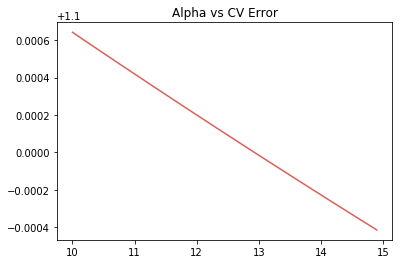

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error")

>We can find at the point of 15 the Error gets to the minimal, so the HyperParameter to this model we can choose __15__
>

In [68]:
#Fitting the Model
ridge = Ridge(alpha=15)
ridge.fit(x_train, y_train)
y_ridge = np.expm1(ridge.predict(x_test)) *4350.0

In [69]:
# Show the result of Prediction
result_df = pd.DataFrame(data= {'Id' : x_test.index, 'SalePrice': y_ridge})
result_df.head(10)

,Id,SalePrice
0,1,7.004549e+06
1,2,7.029787e+06
2,5,6.848287e+06
3,7,7.076154e+06
4,8,8.313674e+06
5,10,5.425891e+06
6,20,6.824321e+06
7,30,6.919778e+06
8,36,6.734763e+06
9,48,7.261530e+06
